# Экспедиции в Гималаи

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns

from scipy.stats import beta
from scipy.special import btdtri
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit

import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.size'] = 12.
plt.rcParams['axes.titlesize'] = 'x-large'
plt.rcParams['axes.titleweight'] = 'bold'

Подготовленные данные к этой работе в виде csv-файлов были взяты из репозитория [Tidy Tuesday](https://github.com/rfordatascience/tidytuesday/tree/master/data/2020/2020-09-22). Исходные данные получены из проекта [The Himalayan Database](https://www.himalayandatabase.com/)

In [2]:
expeditions_csv = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-09-22/expeditions.csv"
members_csv = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-09-22/members.csv"
peaks_csv = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-09-22/peaks.csv"

In [3]:
expeditions_df = pd.read_csv(expeditions_csv)
members_df = pd.read_csv(members_csv)
peaks_df = pd.read_csv(peaks_csv)

## Предварительная подготовка данных

Вначале проведём некоторую подготовительную работу, чтобы привести данные в удобный для последующего анализа вид. Разобьём результаты экспедиций на три категории: "успех" (Success), "неудача" (Failure) и "другое" (Other). В группу другое включим те результаты экспедиций, успешность которых неочевидна. К таким результатам относятся, например: Unknown (неизвестно), Attempt rumoured (неподтверждённая попытка восхождения), Did not attempt climb (попытка восхождения так и не предпринята), Did not reach base camp (группа не подходила к базовому лагерю).

Кроме того сделаем некоторые косметические изменения в данных, такие как:
* Переобозначим метры с европейского написания на американское `metres` -> `meters`
* Обработаем даты в полях `basecamp_date`, `highpoint_date`, `termination_date`, превратим их из текстового формата в формат `datetime`.
* Создадим новое поле `days_to_highpoint` (количество дней на восхождение).
* Превратим поля `season` и `success` в категориальный формат.

In [4]:
def decide_mission_success(x):
    """Распределить множество возможных результатов экспедиций по трём категориям:
    успех, провал и другое. """
    na_reasons = ["Unknown", "Attempt rumoured", "Did not attempt climb", "Did not reach base camp"]
    
    if 'success' in x.lower():
        return 'Success'
    elif x in na_reasons:
        return 'Other'
    else:
        return 'Failure'

In [5]:
peaks_df = peaks_df.rename(columns={'height_metres': 'height_meters'})
expeditions_df['success'] = expeditions_df['termination_reason'].map(decide_mission_success)
expeditions_df['basecamp_date'] = pd.to_datetime(expeditions_df['basecamp_date'])
expeditions_df['highpoint_date'] = pd.to_datetime(expeditions_df['highpoint_date'])
expeditions_df['termination_date'] = pd.to_datetime(expeditions_df['termination_date'])
expeditions_df['days_to_highpoint'] = (expeditions_df['highpoint_date'] - 
                                       expeditions_df['basecamp_date']).dt.days
expeditions_df['season'] = expeditions_df['season'].astype('category')
expeditions_df['success'] = expeditions_df['success'].astype('category')

## Вершины Гималайских гор
Удивительно, но некоторые вершины Гималайских гор всё ещё не покорены. На графике ниже можно видеть 30 самых высоких пиков в Гималаях, цветом отмечены, какие из них на сегодняшний день имеют статус непокорённых.

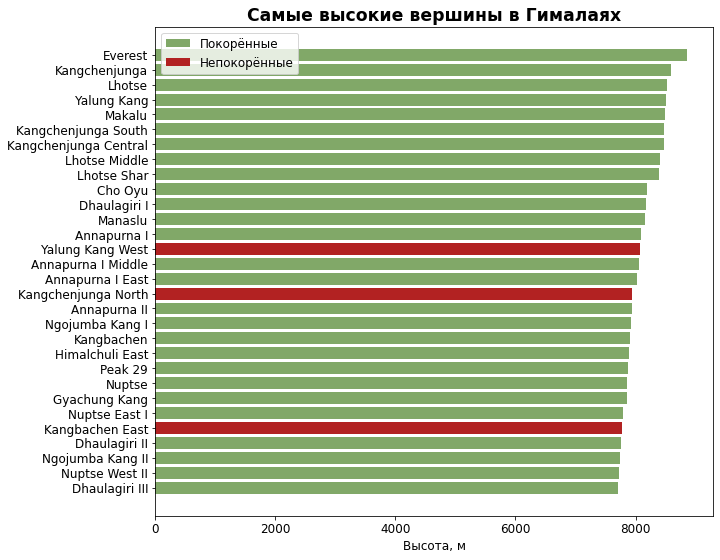

In [6]:
plot_data = peaks_df.sort_values(by='height_meters').tail(30)

colors = {'Climbed': '#81a868', 'Unclimbed': 'firebrick'}
plt.figure(figsize=(10, 9))
bars = plt.barh(y=plot_data['peak_name'],width=plot_data['height_meters'],
         color=[colors[i] for i in plot_data['climbing_status']])
plt.legend((bars[0], bars[4]), ("Покорённые", "Непокорённые"), loc='upper left')
plt.xlabel("Высота, м")
plt.title("Самые высокие вершины в Гималаях")
plt.show()

## Подъёмы на вершины.
Обратим внимание на 10 вершин, которые пытались покорить наибольшее количество людей. Можно увидеть два интересных случая: когда вершину Дхаулагири покоряли в течение более чем 100 дней и когда на Эверест был совершён подъём за менее чем 1 день. 21 мая 2001 года [Пемба Дордже](https://ru.wikipedia.org/wiki/%D0%9F%D0%B5%D0%BC%D0%B1%D0%B0_%D0%94%D0%BE%D1%80%D0%B4%D0%B6%D0%B5) установил рекорд скоростного восхождения на Эверест - 8 часов 10 минут от базового лагеря.

В целом, подъёмы занимают от 10 до 40 дней с довольно большой вариативностью.

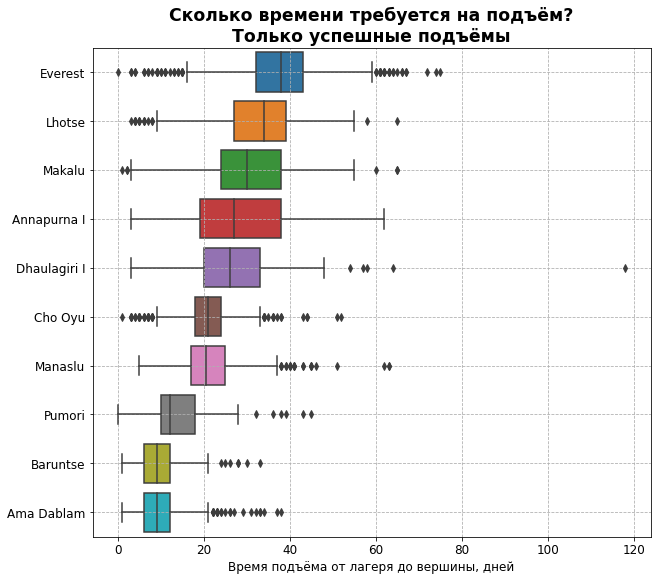

In [9]:
plot_df = expeditions_df.copy()
plot_df = plot_df.dropna(subset=['days_to_highpoint', 'peak_name'])
top10 = (plot_df
         .groupby('peak_name')
         .count()
         .sort_values('expedition_id', ascending=False)[:10]
         .index.to_list())
plot_df = plot_df.loc[(plot_df['success'] == 'Success') & (plot_df['peak_name'].isin(top10))]
order = (plot_df
         .groupby('peak_name')['days_to_highpoint']
         .median()
         .sort_values(ascending=False)
         .index
         .to_list())

plt.figure(figsize=(10, 9))
sns.boxplot(data=plot_df, x='days_to_highpoint', y='peak_name', orient='h', order=order, zorder=100)
plt.grid(ls='--', zorder=0)
plt.xlabel("Время подъёма от лагеря до вершины, дней")
plt.ylabel("")
plt.title("Сколько времени требуется на подъём?\nТолько успешные подъёмы")
plt.show()

## Самые смертоносные горы
В этой секции мы применим Байесианскую оценку вероятности гибели на вершинах Гималаев. На многие пики было совершено слишком мало восхождений, чтобы можно было оценить их опасность методами фреквентистской статистики.

Вначале мы рассчитаем параметры априорного бета-распределения, наилучшим образом описывающего наши данные. Затем для каждой вершины в соответствии с количеством подъёмов и смертей будем рассчитывать математическое ожидание для соответствующих апостериорных распределений.

In [10]:
def summarise_expeditions(df, by='peak_name'):
    summary = df.groupby(by=by).agg(
        {'expedition_id': 'count',
         'success': lambda x: (x=='Success').mean(),
         'members': 'sum',
         'member_deaths': 'sum',
         'hired_staff': 'sum',
         'hired_staff_deaths': 'sum',
         'year': 'min'}
    ).rename(columns={
        'expedition_id': 'n_climb',
        'success': 'pct_success',
        'year': 'first_climb'})
    summary['pct_death'] = summary['member_deaths'] / summary['members']
    summary['pct_hired_staff_deaths'] = summary['hired_staff_deaths'] / summary['hired_staff']
    return summary

In [11]:
peaks_summary_df = summarise_expeditions(expeditions_df)
peaks_summary_df = peaks_summary_df.loc[peaks_summary_df['members'] >=20]
peaks_summary_df = peaks_summary_df.sort_values(by='pct_death', ascending=False)

sample_mean = np.mean(peaks_summary_df['pct_death'])
sample_var = np.var(peaks_summary_df['pct_death'], ddof=1)

# вычисляем параметры бета-распределения
to_fit = pd.Series([x if x != 0 else 1e-8 for x in peaks_summary_df['pct_death']])
a, b, loc, scale = beta.fit(to_fit)

peaks_summary_df['fitted'] = [beta.mean(a+i, b+j-i, loc, scale) 
                              for i, j in zip(peaks_summary_df['member_deaths'], 
                                              peaks_summary_df['members'])]
peaks_summary_df[['cred_low', 'cred_high']] = ([beta.interval(0.9, a+i, b+j-i) 
                                                for i, j in zip(peaks_summary_df['member_deaths'],
                                                                peaks_summary_df['members'])])

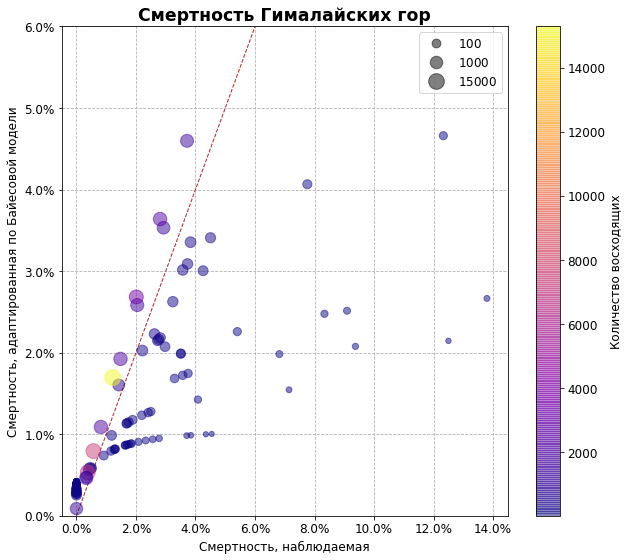

In [28]:
plt.figure(figsize=(10,9))
dots = plt.scatter(x=peaks_summary_df['pct_death'], 
                   y=peaks_summary_df['fitted'],
                   c=peaks_summary_df['members'], alpha=0.5,
                   s=np.log(0.1 * peaks_summary_df['members']) / np.log(1.03), 
                   cmap=plt.cm.plasma,
                   zorder=100)
plt.colorbar(label="Количество восходящих")
plt.axline([0, 0], [1, 1], ls='--', lw=1, c='firebrick')
plt.grid(ls='--')
plt.xlim(-0.005, 0.145)
plt.ylim(0, 0.06)
plt.title('Смертность Гималайских гор')
plt.xlabel("Смертность, наблюдаемая")
plt.ylabel("Смертность, адаптированная по Байесовой модели")
plt.legend(*dots.legend_elements('sizes', num=[100, 1000, 15000], 
                                 func=lambda x: 10*np.power(1.03, x)))
ax = plt.gca()
ax.xaxis.set_major_formatter(PercentFormatter(1))
ax.yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

На графике выше можно видеть соотношение наблюдаемых частот гибели людей при восхождении и оценки вероятностей в соответствии с методами Байесианской статистики. Размеры и цвета точек соответствуют количеству попыток подъёма. Жёлтый цвет и большие точки соответствуют большому количеству попыток  покорения (альпинистов), а фиолетовый цвет и маленькие точки - малому количеству попыток.

Видно, что для малого количества попыток фреквентистская оценка существенно завышена.

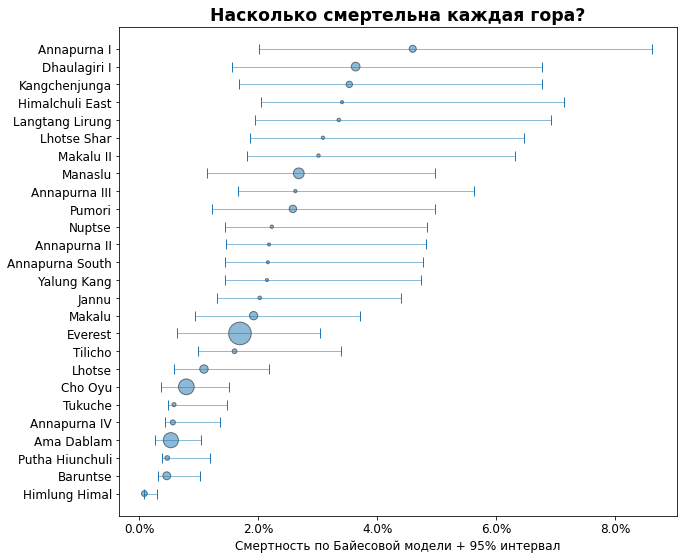

In [29]:
plot_df = peaks_summary_df.copy()
plot_df = plot_df.loc[plot_df['members'] >= 200]
plot_df = plot_df.sort_values(by='fitted', ascending=True)

plt.figure(figsize=(10, 9))
plt.scatter(plot_df['fitted'], plot_df.index, s=plot_df['members']/30 + 2,
            alpha=0.5, ec='k');
plt.errorbar(x=plot_df['fitted'], y=plot_df.index,
             xerr=plot_df[['cred_low', 'cred_high']].values.T, ls='',
             elinewidth=0.5, capsize=5)
ax = plt.gca()
ax.xaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel("Смертность по Байесовой модели + 95% интервал")
plt.title("Насколько смертельна каждая гора?")
plt.show()

## Исследуем Эверест

Подъёмы на Эверест наиболее популярны среди альпинистов.

In [30]:
everest_df = expeditions_df.loc[expeditions_df['peak_name'] == 'Everest']
success_df = expeditions_df.loc[expeditions_df['success'] == 'Success']
print("Количество восхождений на Эверест: {}".format(len(everest_df)))

Количество восхождений на Эверест: 2149


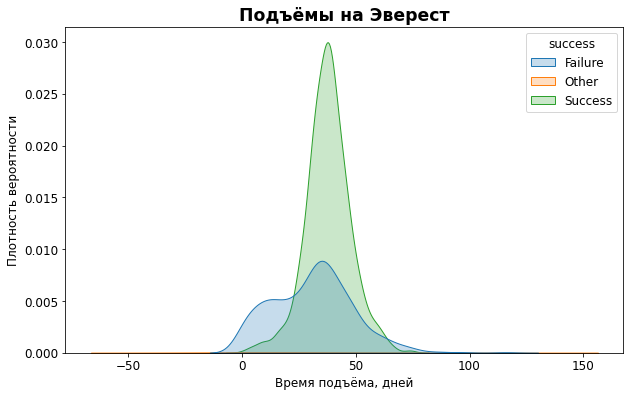

In [14]:
plt.figure(figsize=(10,6))
sns.kdeplot(data=everest_df, x='days_to_highpoint', hue='success', fill=True)
plt.xlabel("Время подъёма, дней")
plt.ylabel("Плотность вероятности")
plt.title("Подъёмы на Эверест")
plt.show()

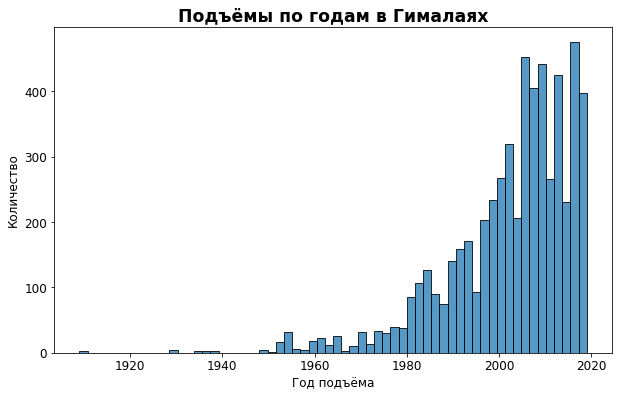

In [48]:
plt.figure(figsize=(10,6))
sns.histplot(data=success_df, x='year')
plt.xlabel("Год подъёма")
plt.ylabel("Количество")
plt.title("Подъёмы по годам в Гималаях")
plt.show()

In [49]:
everest_df['decade'] = np.maximum((everest_df['year'] // 10) * 10, 1970)
everest_decade_df = summarise_expeditions(everest_df, by='decade')

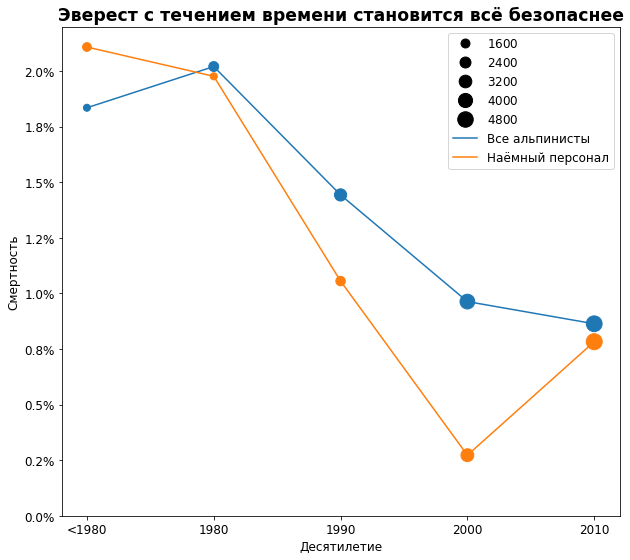

In [50]:
plt.figure(figsize=(10,9))
li1, = plt.plot(everest_decade_df.index, everest_decade_df['pct_death'],
              label="Все альпинисты")
sc1 = plt.scatter(everest_decade_df.index, everest_decade_df['pct_death'],
           s=everest_decade_df['members']/20)
li2, = plt.plot(everest_decade_df.index, everest_decade_df['pct_hired_staff_deaths'],
              label="Наёмный персонал")
sc2 = plt.scatter(everest_decade_df.index, everest_decade_df['pct_hired_staff_deaths'],
           s=everest_decade_df['hired_staff']/20)
plt.ylim(0,0.022)
plt.xlabel("Десятилетие")
plt.ylabel("Смертность")
plt.title("Эверест с течением времени становится всё безопаснее")
ax = plt.gca()
ax.locator_params('x', nbins=5)
ax.set_xticklabels(['', '<1980', '1980', '1990', '2000', '2010'])
ax.yaxis.set_major_formatter(PercentFormatter(1, decimals=1))
handles, labels = sc1.legend_elements('sizes', num=5, func=lambda x: 20*x)
handles.extend([li1, li2])
labels.extend([li1.get_label(), li2.get_label()])
plt.legend(handles, labels)
plt.show()

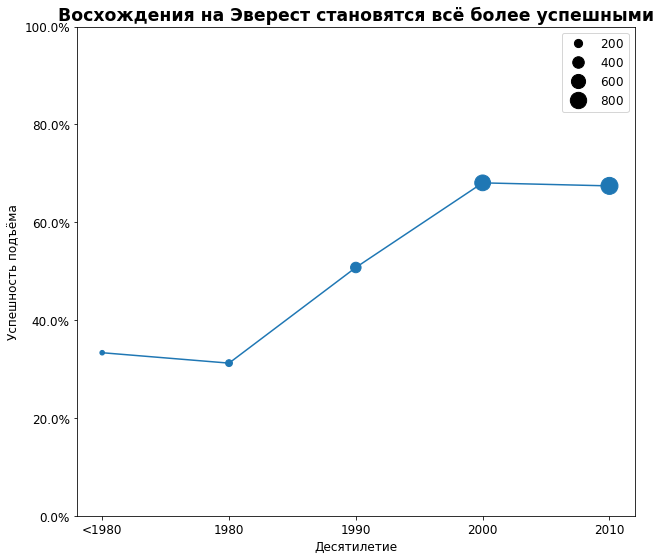

In [51]:
plt.figure(figsize=(10,9))
li, = plt.plot(everest_decade_df.index, everest_decade_df['pct_success'])
sc = plt.scatter(everest_decade_df.index, everest_decade_df['pct_success'],
           s=everest_decade_df['n_climb']/3)
plt.ylim(0,1)
plt.xlabel("Десятилетие")
plt.ylabel("Успешность подъёма")
plt.title("Восхождения на Эверест становятся всё более успешными")
ax = plt.gca()
ax.locator_params('x', nbins=5)
ax.set_xticklabels(['', '<1980', '1980', '1990', '2000', '2010'])
ax.yaxis.set_major_formatter(PercentFormatter(1, decimals=1))
handles, labels = sc.legend_elements('sizes', num=5, func=lambda x: 3*x)
plt.legend(handles, labels)
plt.show()

## Исследование вероятности гибели по данным об альпинистах

In [52]:
members_everest_df = members_df.loc[members_df['peak_name'] == 'Everest']

In [53]:
by_age_df = members_everest_df.set_index('age').groupby(by=lambda x: (x//10)*10).agg(
    {'expedition_id': 'count',
     'died': 'mean'}).rename(
    columns={'expedition_id': 'n_climb',
             'died': 'pct_death'})
by_age_df.index.name = 'age'

In [54]:
model_df = members_everest_df[['died', 'year', 'age', 'sex', 'hired', 'oxygen_used']].copy()
model_df['leader'] = members_everest_df['expedition_role'] == 'Leader'
model_df['sex'] = [(x == 'M') for x in model_df['sex']]
model_df = model_df.rename(columns={'sex': 'male'})
model_df = model_df.dropna()
model_df = model_df.reset_index(drop=True)

In [55]:
sss = StratifiedShuffleSplit(n_splits=20, train_size=0.9)
model = LogisticRegression(class_weight={False: 1, True: 78})
coefs = []
for train_index, test_index in sss.split(model_df.iloc[:,1:], model_df.iloc[:, 0]):
    model.fit(model_df.iloc[train_index, 1:], model_df.iloc[train_index, 0])
    coefs.append(model.coef_[0])

coefs_arr = np.array(coefs)
means = coefs_arr.mean(axis=0)
stds = coefs_arr.std(axis=0)

In [56]:
features = model_df.iloc[:, 1:].columns.to_list()
coefs_df = pd.DataFrame({'Признаки': features,
                         'Коэффициенты': means,
                         'Стандартные отклонения': stds,
                         'error': 2*stds})
coefs_df = coefs_df.sort_values(by='Коэффициенты')
coefs_df

,Признаки,Коэффициенты,Стандартные отклонения,error
4,oxygen_used,-0.547173,0.047817,0.095635
0,year,-0.000339,0.000083,0.000166
1,age,0.012914,0.002233,0.004465
3,hired,0.228591,0.056548,0.113097
2,male,0.324307,0.131845,0.263689
5,leader,0.508641,0.199886,0.399772


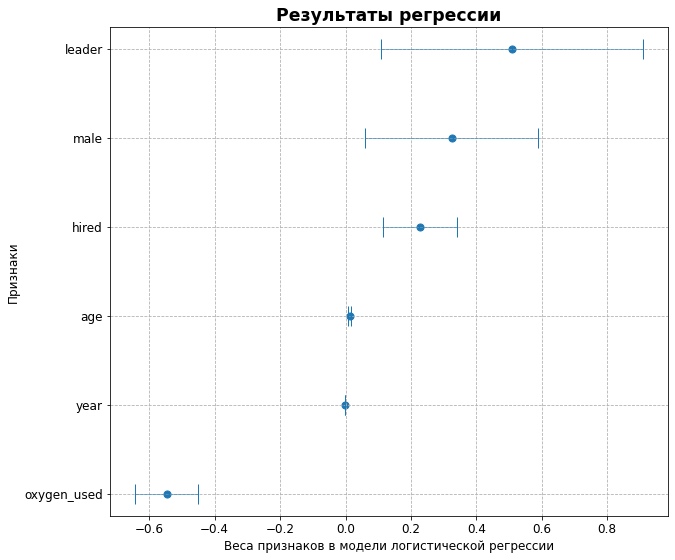

In [57]:
plt.figure(figsize=(10,9))
plt.scatter(coefs_df.iloc[:, 1], coefs_df.iloc[:, 0], s=50)
plt.errorbar(x=coefs_df.iloc[:, 1], y=coefs_df.iloc[:, 0],
            xerr=coefs_df['error'], ls='', capsize=10, elinewidth=0.5)
plt.xlabel('Веса признаков в модели логистической регрессии')
plt.ylabel('Признаки')
plt.title('Результаты регрессии')
plt.grid(ls='--')
plt.show()